In [1]:
import os
from typing import Final, List
import warnings
warnings.filterwarnings('ignore')
import gym
import gym_md
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, DQN
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from PIL import Image
import imageio
from util import debug_env
import matplotlib.colors as c
import matplotlib.animation as animation


2024-04-02 12:17:16.161515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Global variables
obs_names = ['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP']
obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']

class_names = ['MONSTER','TREASURE','TREASURE_SAFELY','POTION','POTION_SAFELY','EXIT','EXIT_SAFELY']
LENGTH: Final[int] = 20

tiles_dir = "gym_md/envs/tiles"
tiles_names: Final[List[str]] = [
    "empty.png",
    "wall.png",
    "chest.png",
    "potion.png",
    "monster.png",
    "exit.png",
    "hero.png",
    "deadhero.png",
]
tiles_paths: Final[List[str]] = [os.path.join(tiles_dir, t) for t in tiles_names]
tiles_images = [Image.open(t).convert("RGBA") for t in tiles_paths]
split_images = [[x for x in img.split()] for img in tiles_images]

BASE_ACTION_MAP ={
    'KILLER': 1,
    'POTION': 4, 
    'RUNNER': 3, 
    'TREASURE': 2
}

legend_labels ={
    # "white":'Not Visited', 
    "green":'Killer', 
    "yellow":'Treasure', 
    "blue":'Runner',
    "red":'Potion', 
}
colors = {
    "white":0, 
    "green":1, 
    "yellow":2, 
    "blue":3,
    "red":4, 
    # "gray":5, 
    # "lightgreen":6, 
    # "lightblue":7,  
    # "lightcoral":8, 
    # "brown":9,
    # "violet":10, 
    # "blueviolet":11, 
    # "indigo":12, 
    # "khaki":13, 
    # "orange":14, 
    # "pink":15, 
    # "black":16
}
l_colors = sorted(colors, key=colors.get)
cMap = c.ListedColormap(l_colors)

In [3]:
def get_exp_details(name):
    config = {}
    var = name.split('_')
    # print(var)
    if len(var[1])==1 and var[2]=='not':
        # print("len(var[1])==1 and var[2]!='not'")
        # check_1_not_original_clearer_risky_baseline
        # check_1_original_optimal_baseline
        config['lvl'] = f"{var[0]}_{var[1]}"
        config['reward_scheme'] = f"{var[2]}_{var[3]}"
        config['play_style'] = f"{var[4]}_{var[5]}"
        config['exp_type'] = var[6]
    # elif len(var[1])==1 and 'not' in var and 'optimal' in var: 
    #     # check_1_not_original_clearer_risky_baseline
    #     # print("len(var[1])==1 and 'not' in var and 'optimal' in var")
    #     config['lvl'] = f"{var[0]}_{var[1]}"
    #     config['reward_scheme'] = f"{var[2]}_{var[3]}"
    #     config['play_style'] = f"{var[4]}_{var[5]}"
    #     config['exp_type'] = var[6]
    elif len(var[1])==1 and var[2]!='not':
        # print("len(var[1])==1 and 'not' not in var and 'optimal' not in var")
        # check_1_not_original_clearer_risky_baseline
        # check_1_original_optimal_baseline
        # 'policy_1_treasure_fifty_twoFifty_rewardShaping_6'
        config['lvl'] = f"{var[0]}_{var[1]}"
        config['reward_scheme'] = var[2]
        config['play_style'] = var[3]
        config['exp_type'] = var[4]
    elif len(var[1])!=1 and var[2]=='not':
        # hard_not_original_clearer
        config['lvl'] = var[0]
        config['reward_scheme'] = f"{var[1]}_{var[2]}"
        config['play_style'] = f"{var[3]}_{var[4]}"
        config['exp_type'] = var[5]
    else:
        print("else")
        # hard_not_original_clearer_safe_baseline
        config['lvl'] = var[0]
        config['reward_scheme'] = var[1]
        config['play_style'] = var[2]
        config['exp_type'] = var[3]

    # print(config)
    return config


def get_reshape(row):
    # print(row)
    return np.fromstring(row['grid'].replace('\n','')
                .replace('[','')
                .replace(']','')
                .replace('  ',' '), sep=' ').reshape(row['grid_rows'],row['grid_columns'])


def gen_action_map(df, f):
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for index, row, in df.iterrows():
        x, y, action = row['x'], row['y'], row['action']
        if action in BASE_ACTION_MAP:
            grid[y, x] = BASE_ACTION_MAP[action]
    # print(grid)
    #TDOD Look into decrete colormaps for heatmap
    heat =sns.heatmap(grid,cmap=l_colors,vmin=0,vmax=len(colors)-1,alpha =0.4,zorder=2,cbar=False)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.keys()]
    # heat =
    my_image = cv2.imread(f)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    # print(heat.get_aspect())
    # colorbar = heat.collections[0].colorbar
    # colorbar.set_ticks([1,2,3,4])
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_labels.keys()]
    img = heat.imshow(my_image,extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    plt.legend(markers, legend_labels.values(), numpoints=1, loc= 1,bbox_to_anchor=(1.1, 2.2))

    img = convert_fig(plt)
    plt.clf()
    return img

def gen_action_data_img(configs):
    print('----------Generating Action Data----------')
    
    images =[]
    dfs =[]
    for config in configs:
        # plt.clear()
        if config['action_type']=='switch':
            data =gen_data(config)
            lvl = config['lvl']
            img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png'
            df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
            dfs.append(df)
            try:
                img =gen_action_map(df, img_path)
                images.append(img)
            except:
                img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg'
                img =gen_action_map(df, img_path)
                images.append(img)
        elif config['action_type']=='base':
            
            data =gen_data(config)
            lvl = config['lvl']
            img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png'
            df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
            dfs.append(df)
            try:
                img =gen_heatmap(df, img_path)
                images.append(img)
            except:
                img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg'
                img =gen_heatmap(df, img_path)
                images.append(img)
    
    return dfs, images

def gen_heatmap(df,f):
    df = df.reset_index()
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for i, j in zip(y_array,x_array):
        grid[i,j]+=1
    heat =sns.heatmap(grid,cmap='viridis',alpha =0.4,zorder=2, cbar = False)
    my_image = cv2.imread(f)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    # print(heat.get_aspect())
    img = heat.imshow(my_image,extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    img = convert_fig(plt)
    plt.clf()
    return img

def gen_data(config):   
    print('----------Generating Data----------')
    
    # set variables
    data =[]
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']

    if action_type == 'switch':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    else:
        env = gym.make(f"md-{lvl}-v0")
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"


    env.setting.IS_ENEMY_POWER_RANDOM =False
    if play_style=='killer':
        env.setting.PLAYER_MAX_HP = 10000

    print(exp)
    if action_type =='base':
        model = PPO.load(f"{path}/{play_style}.zip")  # loading the model from ppo_cartpole.zip 
    elif action_type == 'path':
        model = PPO.load(f"logs/{path}/{exp}/best_model/best_model") 
    elif algo == 'DQN':
        model = DQN.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
    else:
        model = PPO.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
                                                                                     
    curr_obs = env.reset()  
    curr_grid = np.array(env.grid.g)
    # data.append([exp, lvl, 0, -1, env.agent.x, env.agent.y, env.agent.hp, start_grid, play_style, "NO_ACTION",curr_obs, curr_obs, False, 0, dict(env.info),start_grid.shape[0],start_grid.shape[1]])

    for ep in range(10):                                                                    
        for i in range(1000): 
            agent_x = env.agent.x
            agent_y = env.agent.y
            agent_hp = env.agent.hp                                                                  
            action, _state = model.predict(curr_obs, deterministic=True) 
            action = action.tolist()                  
            obs, reward, done, info = env.step(action) 
            grid= np.array(env.grid.g)  
            data.append([exp, lvl, ep,i, agent_x, agent_y, agent_hp, curr_grid,grid, play_style, info['action_taken'],curr_obs, obs, done, reward, dict(info),grid.shape[0],grid.shape[1]])
                                                
            # env.render(mode='human')                                                                        
            if done:                                                                            
                obs = env.reset()
                break

            curr_obs= obs
            curr_grid = grid
                
    return data

def gen_data_and_img(config):
    data =gen_data(config)
    lvl = config['lvl']
    img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png'
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    try:
        action_img = gen_action_map
        img =gen_heatmap(df, img_path)
    except:
        img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg'
        img =gen_heatmap(df, img_path)
    return df,img

def convert_fig(plt):
    # Get the figure and its axes
    fig = plt.gcf()
    axes = plt.gca()

    # Draw the content
    fig.canvas.draw()

    # Get the RGB values
    rgb = fig.canvas.tostring_rgb()

    # Get the width and height of the figure
    width, height = fig.canvas.get_width_height()

    # Convert the RGB values to a PIL Image
    img = Image.frombytes('RGB', (width, height), rgb)
    img_array = np.array(img)
    return img_array


class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = self.policy_net(x)
        x = self.action_net(x)
        return x

class sb3_DQN_wrapper(nn.Module):
    def __init__(self, model):
        super(sb3_DQN_wrapper,self).__init__()
        self.q_net = model.policy.q_net.q_net
        self.q_net_target = model.q_net_target.q_net

    def forward(self,x):
        x = self.q_net(x)
        return x
    
    def forward_target(self,x):
        x = self.q_net_target(x)
        return x

def shap_behaviour(config):
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']
    #generate data
    data =gen_data(lvl=lvl, play_style=play_style, reward_scheme=reward_scheme, exp_type=exp_type, path=path)
    df = pd.DataFrame(data, columns=['experiment','level','run','x','y','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    print(df[['action','observation']])
    #load PPO model
    if action_type == "switch":
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        model_path = f"logs/{path}/{lvl}_{play_style}_{reward_scheme}_{exp_type}/best_model/best_model"
    # else:

    # if algo =="PPO":
    #     model = PPO.load(model_path, device='cuda')
    # elif algo =='DQN':
        model = DQN.load(model_path, device='cuda')
    state_log = np.array(df['curr_obs'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    model = sb3Wrapper(model)
    explainer = shap.DeepExplainer(model, data)
    # explainer=shap.KernelExplainer(model.policy.,state_log)
    shap_vals= explainer.shap_values(data)

    return explainer, shap_vals, data, df

from numpy import float64
from torch import float32
from torch.autograd import Variable

def shappy(config,explainer_type ='deep'):
    print('----------Perfroming Shapley Analysis----------')
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']
    #generate data
    data =gen_data(config)
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    # print(df[['action','observation']])
    #load PPO model
    if action_type == "switch":
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        model_path = f"logs/{path}/{exp}/{play_style}/best_model"
    else:
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"
        model_path = f"logs/{path}/{exp}/best_model/best_model"

    if algo =="PPO":
        model = PPO.load(model_path, device='cuda')
    elif algo =='DQN':
        model = DQN.load(model_path, device='cuda')
    state_log = np.array(df['curr_obs'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    # print(model.policy)
    # print(model.policy.q_net.q_net)
    if algo =='PPO':
        model = sb3Wrapper(model)
    elif algo == 'DQN':
        model = sb3_DQN_wrapper(model)
    

    if explainer_type == "kernel":
        f = lambda x: model.forward(Variable(torch.from_numpy(x)).to(float32).cuda()).detach().cpu().numpy()
        explainer = shap.KernelExplainer(f, state_log)
        shap_vals= explainer.shap_values(state_log)

    else:
        explainer = shap.DeepExplainer(model, data)
        shap_vals= explainer.shap_values(data,check_additivity=True)

    # explainer=shap.Explainer(model.forward,data)
    # shap_vals= explainer.shap_values(state_log)
    # return
    return explainer, shap_vals, data, df


def shap_behaviour_gif(lvl,play_style,reward_scheme,exp_type,path,gif_type):
    #generate data
    data =gen_data(lvl=lvl, play_style=play_style, reward_scheme=reward_scheme, exp_type=exp_type, path=path)
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','grid','play_style','action','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    print(df[['action','observation']])
    #load PPO model

    model_path = f"logs/{path}/{lvl}_{play_style}_{reward_scheme}_{exp_type}/best_model/best_model"
    exp_name = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"
    model = PPO.load(model_path, device='cuda')
    state_log = np.array(df['observation'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    model = sb3Wrapper(model)

    images = []
    if gif_type == "state_inc":
        for i in tqdm(range(len(state_log))):
            # print(data[:i+1,:])
            # data = torch.FloatTensor(state_log).to('cuda')
            cur_data = data[:i+1,:]
            explainer = shap.DeepExplainer(model, cur_data)
            shap_vals= explainer.shap_values(cur_data)
            shap.summary_plot(shap_vals,cur_data, feature_names=obs_names,class_names= class_names,plot_type='bar', show =False)
            plt.title(f'{exp_name}\n states used: {i}')
            images.append(convert_fig(plt))
            plt.clf()
    elif gif_type== "play":
        for i in tqdm(range(len(state_log))):
            cur_data = data[i]
            explainer = shap.DeepExplainer(model, cur_data)
            shap_vals= explainer.shap_values(cur_data)
            action = df['action'].iloc[i]
            shap.force_plot(shap_vals,cur_data, feature_names=obs_names,class_names= class_names,plot_type='bar', show =False)
            plt.title(f'{exp_name}\n states used: {i}')
            images.append(convert_fig(plt))
            plt.clf()
        
    print(images)
    imageio.mimsave(f'./shap/shap_gifs/{exp_name}.gif',images,format='GIF')

    return explainer, shap_vals, data, df

shap.initjs()

In [4]:
config ={
    'action_type': 'switch',
    'lvl': 'policy_2',
    'play_style': 'switch',
    'reward_scheme': 'exitLessBetter',
    'exp_type': 'switch',
    'learning_algo': 'PPO',
    'exp_path': 'switching',
}
config_base_treasure={
    'action_type': 'base',
    'lvl': 'policy_2',
    'play_style': 'treasure',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'treasure',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_killer={
    'action_type': 'base',
    'lvl': 'policy_2',
    'play_style': 'killer',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'killer',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_potion={
    'action_type': 'base',
    'lvl': 'policy_2',
    'play_style': 'potion',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'potion',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_runner={
    'action_type': 'base',
    'lvl': 'policy_2',
    'play_style': 'runner',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'runner',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_killer ={
    'action_type': 'path',
    'lvl': 'policy_2',
    'play_style': 'killer',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'rewardShapingKillerLonger_1',
    'learning_algo': 'PPO',
    'exp_path': 'reward_shaping/',
}

lvl = config['lvl']
img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png'

config_h9={
    'action_type': 'switch',
    'lvl': 'holmgard_9',
    'play_style': 'switch',
    'reward_scheme': 'exitLessBetter4',
    'exp_type': 'switch',
    'learning_algo': 'PPO',
    'exp_path': 'switching',
}
config_base_treasure_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'treasure',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'treasure',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_killer_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'killer',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'killer',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_potion_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'potion',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'potion',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_runner_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'runner',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'runner',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
h9_config_killer_h9 ={
    'action_type': 'path',
    'lvl': 'holmgard_9',
    'play_style': 'killer',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'rewardShapingKillerLonger_1',
    'learning_algo': 'PPO',
    'exp_path': 'reward_shaping/',
}

In [5]:
configs = [config]
df =gen_action_data_img(configs)
# plt.imshow(df)

# df

switch-policy_2_switch_exitLessBetter_switch_PPO


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


<Figure size 640x480 with 0 Axes>

switch-policy_2_switch_exitLessBetter_switch_PPO


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


policy_2_treasure_fiftytwoFifty_treasure


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


policy_2_killer_fiftytwoFifty_killer


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


policy_2_potion_fiftytwoFifty_potion


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


policy_2_runner_fiftytwoFifty_runner


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


5


<Figure size 640x480 with 0 Axes>

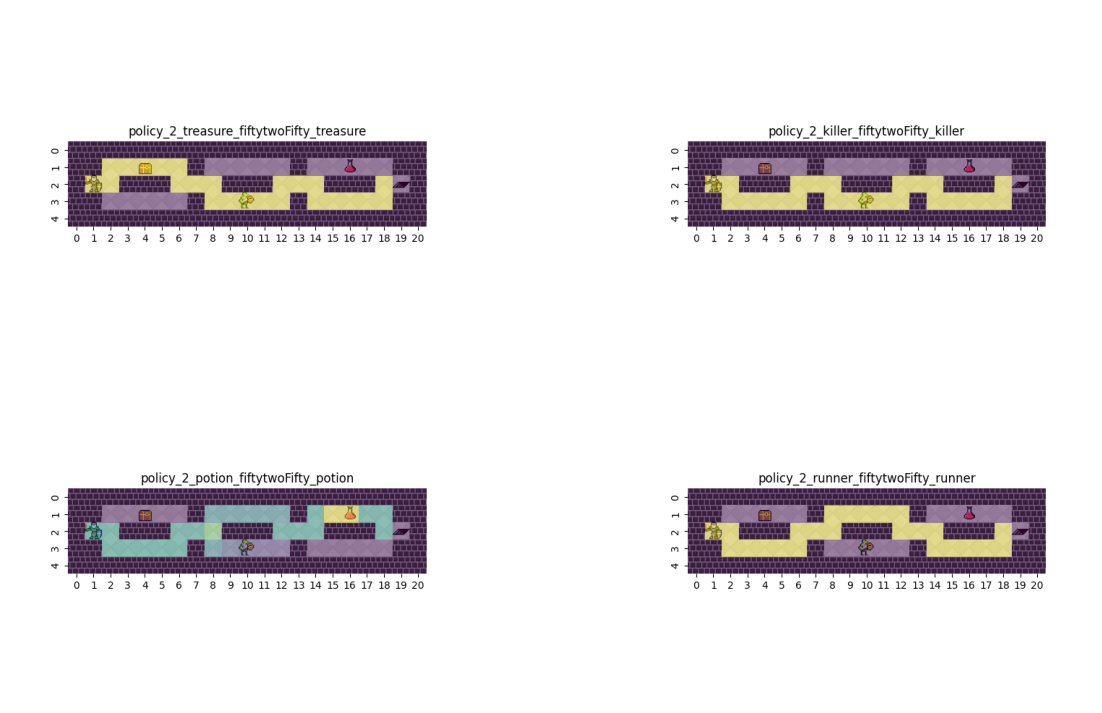

(-0.5, 639.5, 479.5, -0.5)

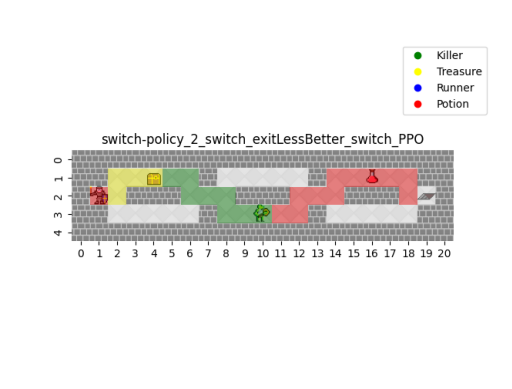

In [6]:
configs = [config, config_base_treasure,config_base_killer,config_base_potion,config_base_runner]
df, images =gen_action_data_img(configs)
print(len(images))

f, axarr = plt.subplots(2,2, figsize=(16,9))
axarr[0,0].imshow(images[1])
axarr[0,0].axis('off')
axarr[0,0].set_aspect('equal')

axarr[0,1].imshow(images[2])
axarr[0,1].axis('off')
axarr[0,1].set_aspect('equal')
axarr[1,0].imshow(images[3])
axarr[1,0].axis('off')
axarr[1,0].set_aspect('equal')
axarr[1,1].imshow(images[4])
axarr[1,1].axis('off')
axarr[1,1].set_aspect('equal')
plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.show()
axarr[1,1].axis('off')
plt.imshow(images[0])
plt.axis('off')




switch-policy_2_switch_exitLessBetter_switch_PPO


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


action
POTION      119
KILLER       80
TREASURE     41
Name: count, dtype: int64


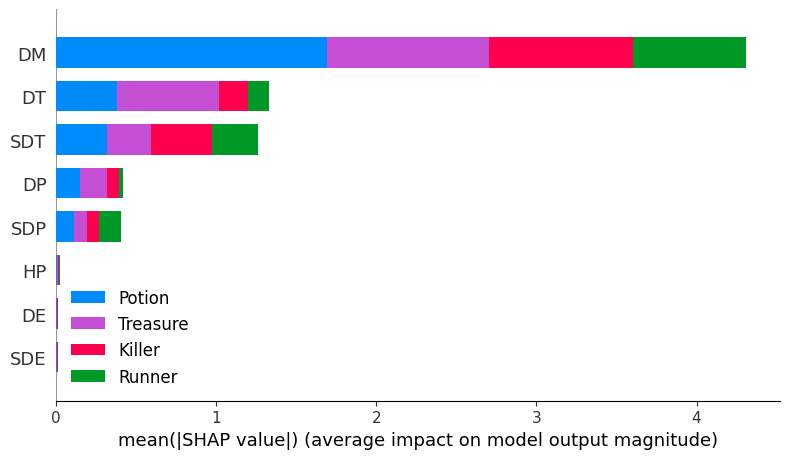

In [7]:
plt.clf()
plt.close()

explainer, shap_vals, data, df =shappy(config, 'deep')
shap.summary_plot(shap_vals,data, feature_names=obs_names, class_names =['Killer','Treasure','Runner','Potion'],plot_type='bar')
# shap.plots.waterfall(explainer.expected_value[0],shap_vals[0])

In [5]:
policy_classes = ['killer','treasure','runner','potion']
EXPLAINER_TYPE = "deep"

def shap_index(explainer,data,df, index):
    i = index
    print(df.iloc[index])
    if EXPLAINER_TYPE == 'deep':
        index_data = data[i:i+1]
        print(index_data)
        shap_val_single = explainer.shap_values(X=index_data, check_additivity=True)
        # get action taken
        action = df['action'].iloc[i]
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        exp = shap.Explanation(shap_val_single[action_idx][0], explainer.expected_value[action_idx], data = df['curr_obs'].values[i], feature_names=obs_names)
    elif EXPLAINER_TYPE == "kernel":
        shap_val_single = explainer.shap_values(X = df['curr_obs'].values[i])
        index_data = df['curr_obs'].values[i]
            # get action taken
        action = df['action'].iloc[i]
        # print(action)
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        #TODO add action to images
        # print(shap_val_single[action_idx])

        exp = shap.Explanation(shap_val_single[action_idx], explainer.expected_value[action_idx], data = df['curr_obs'].values[i], feature_names=obs_names)
    # print(exp)
    try:
        imgs = shap.plots.waterfall(exp, show = False)
    except:
        imgs = shap.plots.waterfall(shap_val_single)
    plt.title(f"Action: {action}")
    plt.show()
    # print(img[0])
    # plt.clf()
    # img =shap.plots.force(base_value=explainer.expected_value[action_idx],shap_values=shap_val_single[action_idx],features=df['curr_obs'].iloc[i].tolist(),feature_names=obs_names,matplotlib=True,show=False,
    #                       figsize = (20,4))
    imgs = convert_fig(plt)
    # print(imgs)
    # plt.clf()
    return imgs

shap_index(explainer,data,df, 1)

NameError: name 'explainer' is not defined

In [9]:
# shap.plots.force(base_value=explainer.expected_value[0],shap_values=shap_val_single[0],features=df['observation'].iloc[0].tolist(),feature_names=obs_names,matplotlib=True)
df.head()
i=1
df['curr_obs'].values[i]
print(data[i:i+1][0])

tensor([ 11.,   3.,   3.,  19.,  19.,  23.,  23., 100.], device='cuda:0')


In [6]:
# from pipeline.ipynb:pylance-notebook-cell:X12sdnNjb2RlLXJlbW90ZQ== import CLASS_NAMES
# look into adding the general explainer as an otion for explainer type

policy_classes = ['killer','treasure','runner','potion']
EXPLAINER_TYPE = "deep"
CLASS_NAMES =['Killer','Treasure','Runner','Potion']


def gen_config():
    return

def shap_index(explainer,data,df, index):
    #TODO Look  into barplot and chorts
    #https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
    i = index
    if EXPLAINER_TYPE == 'deep':
        index_data = data[i:i+1]
        shap_val_single = explainer.shap_values(X=index_data)
        # get action taken
        action = df['action'].iloc[i]
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        exp = shap.Explanation(shap_val_single[action_idx][0], explainer.expected_value[action_idx], data = df['curr_obs'].values[i], feature_names=obs_names)
    elif EXPLAINER_TYPE == "kernel":
        shap_val_single = explainer.shap_values(X = df['curr_obs'].values[i])
        index_data = df['curr_obs'].values[i]
        # get action taken
        action = df['action'].iloc[i]
        action_idx = policy_classes.index(action.lower())
        exp = shap.Explanation(shap_val_single[action_idx], explainer.expected_value[action_idx], data = df['curr_obs'].values[i], feature_names=obs_names)

    try:
        imgs = shap.plots.waterfall(exp, show = False)
    except:
        imgs = shap.plots.waterfall(shap_val_single)
    plt.title(f"Action: {action}")
    plt.rcParams['figure.constrained_layout.use'] = True
    imgs = convert_fig(plt)

    return imgs


def shap_state(explainer,df,data, state):
    # get index of states
    state_idx = df['observation'].tolist()
    print(state_idx)
    for i in range( len(state_idx)):
        if state_idx[i].tolist() == state:
            state_idx = i
            break
    print(state_idx)
    action=df['action'].iloc[state_idx]
    action_idx = policy_classes.index(action.lower())
    shap_val_state = explainer.shap_values(X=data[state_idx:state_idx+1,:])
    
    shap.summary_plot(shap_val_state[action_idx],data, feature_names=obs_names,plot_type='bar')
    img = convert_fig(plt)
    return img
# print(shap_state(explainer,df,data, [11, 3, 3, 19, 19, 23, 23, 100]))

def action_shap(shap_vals,data, action, loc):
    action_idx = policy_classes.index(action.lower())
    shap.summary_plot(shap_vals[action_idx],data, feature_names=obs_names, class_names =['Killer','Treasure','Runner','Potion'],plot_type='bar', show=False)
    plt.title(f"Summary for {action.lower()} Policy")
    plt.savefig(f"{loc}{action.lower()}_policy_action.png")
    

def state_image(grid, agent_x, agent_y,agent_hp):
    # tiles_dir = os.path.join(os.path.dirname(__file__), os.path.pardir, "gym_md/envs/tiles")
    H = grid.shape[0]
    W = grid.shape[1]

    img = Image.new("RGB", (W * LENGTH, H * LENGTH))
    for i in range(H):
        for j in range(W):
            img.paste(tiles_images[0], (LENGTH * j, i * LENGTH))
            e: int = grid[i, j]
            if i == agent_y and j == agent_x:
                e = 6 if agent_hp > 0 else 7
            img.paste(tiles_images[e], (LENGTH * j, i * LENGTH), split_images[e][3])
    # maybey convert to array
    # print(img)
    # img = convert_fig(plt)
    # print(img)
    return img
def make_state_gif(images,file_name_loc):

    duration = len(images)*100
    print(duration)
    images[0].save(file_name_loc, format = "GIF",save_all=True, append_images= images[1:], transparency=0, duration= 1000, disposal=2, loop=0)
    
def make_shap_gif(images,file_name_loc):
    imageio.mimsave(file_name_loc,images,format='GIF', duration=1000)

def get_concat_h_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def merge_gifs(file1:str,file2:str,output_loc:str):
    #Create reader object for the gif
    gif1 = imageio.get_reader(file1)
    gif2 = imageio.get_reader(file2)

    # Get the frame count for each GIF
    num_frames1 = gif1.get_length()
    num_frames2 = gif2.get_length()

    # Determine the width and height of the resulting GIF
    width = gif1.get_data(0).shape[1] + gif2.get_data(0).shape[1]
    height = max(gif1.get_data(0).shape[0], gif2.get_data(0).shape[0])
    print(width, height)
    # print(gif1.get_meta_data())

    # Create a writer object for the resulting GIF
    output_gif = imageio.get_writer(output_loc, duration=gif1.get_meta_data()['duration'])
    merged_image_list = []

    # Loop through frames and merge them side by side
    for frame1, frame2 in zip(gif1, gif2):
        merged_frame = get_concat_h_blank(Image.fromarray(frame1),Image.fromarray(frame2))
        output_gif.append_data(merged_frame)
        merged_image_list.append(merged_frame)

    merged_image_list[0].save(f"{output_loc}.pdf", save_all = True, append_images= merged_image_list[1:])
    # Close the output GIF writer
    gif1.close()
    gif2.close()  
    output_gif.close()


def play_thru_analysis(explainer, shap_vals,data, df, loc):
    #create figure space
    # fig, (ax1, ax2) = plt.subplots(2,1)
    # iterate every
    grid_array =[]
    shap_array =[]
    images = []
    for index, row in df.iterrows():
        if row['run'] ==0:
            # grid_img = ax1.imshow(state_image(row['curr_grid'], row['x'],row['y'],row['hp']))
            grid_array.append(state_image(row['curr_grid'], row['x'],row['y'],row['hp']))
            plt.clf()
            # print(shap_index(explainer,data,df, index))
            # shap_img = ax2.imshow(shap_index(explainer,data,df, index))
            shap_array.append(Image.fromarray(shap_index(explainer,data,df, index)))
            plt.clf()
            # images.append([grid_img, shap_img])
    shap_file_loc = f'./{loc}/shap_gif.gif'
    state_file_loc = f'./{loc}/state_gif.gif'
    output = f'./{loc}/play_through_gif.gif'
    print(shap_array)
    make_state_gif(grid_array,state_file_loc)
    make_state_gif(shap_array,shap_file_loc)

    merge_gifs(state_file_loc,shap_file_loc,output)

def gen_config(lvl:str, algo:str, obs_type:str, switch_path:str, base_path:str ='play_style_models/base/'):
    config_switch ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'switch',
        'reward_scheme': 'switch',
        'exp_type': 'switch_analysis',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
    }
    config_hard ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'hard',
        'reward_scheme': 'hard',
        'exp_type': 'switch_analysis',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
    }
    config_treasure ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'treasure',
        'reward_scheme': 'treasure',
        'exp_type': 'switch_analysis',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
    }
    config_killer ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'killer',
        'reward_scheme': 'killer',
        'exp_type': 'switch_analysis',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
    }
    config_potion ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'potion',
        'reward_scheme': 'potion',
        'exp_type': 'switch_analysis',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
    }
    config_runner ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'runner',
        'reward_scheme': 'runner',
        'exp_type': 'switch_analysis',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
    }
    config_base_treasure={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'treasure',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'treasure',
        'learning_algo': f'{algo}',
        'exp_path': f'{base_path}',
    }
    config_base_killer={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'killer',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'killer',
        'learning_algo':f'{algo}',
        'exp_path': f'{base_path}',
    }
    config_base_potion={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'potion',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'potion',
        'learning_algo': f'{algo}',
        'exp_path': f'{base_path}',
    }
    config_base_runner={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'runner',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'runner',
        'learning_algo': f'{algo}',
        'exp_path': f'{base_path}',
    }

    return [config_switch, config_hard,config_treasure,config_killer, config_potion, config_runner, config_base_treasure, config_base_killer, config_base_potion, config_base_runner]

def qauntitative_results(explainer, shap_vals, data, df):
    #TODO look into averaging the shap vals
    
    #average actions taken
    df

    # add shap values for each state to the dataframe

    # get the top n shapley value indecies for each state and add to the data frame
    # count and average the top shap indecies
    # create an image showing the top actions and top shap values 
    return 

def gen_analysis(analysis_loc,lvl, obs_type, explainer_type):
    #TODO check if analysis loc exists and create folder if not
    #TODO make this include hard analysis
    #params
    #gen config
    configs = gen_config(lvl = lvl, algo='PPO', obs_type = obs_type, switch_path='switching_analysis', base_path='play_style_models/base/')
    print(len(configs))
    #gen and save images
    df, images = gen_action_data_img(configs)
    f, axarr = plt.subplots(2,2, figsize=(16,9))
    axarr[0,0].imshow(images[-4])
    axarr[0,0].axis('off')
    axarr[0,0].set_aspect('equal')

    axarr[0,1].imshow(images[-3])
    axarr[0,1].axis('off')
    axarr[0,1].set_aspect('equal')
    axarr[1,0].imshow(images[-2])
    axarr[1,0].axis('off')
    axarr[1,0].set_aspect('equal')
    axarr[1,1].imshow(images[-1])
    axarr[1,1].axis('off')
    axarr[1,1].set_aspect('equal')
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.savefig(f"{analysis_loc}/base_play-styles.png")
    plt.show()
    plt.clf()
    axarr[1,1].axis('off')
    plt.imshow(images[0])
    plt.axis('off')
    plt.savefig(f"{analysis_loc}/switching.png")
    plt.show()
    plt.clf()
    plt.imshow(images[1])
    plt.axis('off')
    plt.savefig(f"{analysis_loc}/switching.png")
    plt.show()
    plt.clf()

    #TODO fix summary saving plots
    switch_analysis = ['switch','hard','treasure','killer','potion','runner']
    # iteratively create analysis for all the siwtching agents using 
    for i, switch_type in enumerate(switch_analysis):
        sub_path = f'{analysis_loc}{switch_type}/' 
        os.makedirs(sub_path,exist_ok=True)   

        plt.imshow(images[i])
        plt.axis('off')
        plt.savefig(f"{sub_path}switching.png")
        plt.show()
        plt.clf()
        #shap stuff
        #explain switcher on switching rewward
        explainer , shap_vals, data, df =shappy(configs[i], explainer_type=explainer_type)

        # perform quantitative analysis

        plt.clf()
        shap.summary_plot(shap_vals,data, feature_names=obs_names, class_names =['Killer','Treasure','Runner','Potion'],plot_type='bar',show=False)
        plt.savefig(f"{sub_path}Summary.png")
        plt.clf()

        for policy in CLASS_NAMES:
            #TODO fix saving plots
            action_shap(shap_vals=shap_vals, data = data, action= policy, loc =f"{sub_path}")
            plt.clf()

        # gen and save gifs
        play_thru_analysis(explainer,shap_vals,data,df, f"{sub_path}")
        plt.clf()


plt.close()
# play_thru_analysis(explainer,shap_vals,data,df)

# gen_analysis(analysis_loc='./test_analysis/Policy_2_Analysis/', lvl='policy_2', explainer_type =EXPLAINER_TYPE)


In [8]:
EXPLAINER_TYPE = 'deep'
CLASS_NAMES =['Killer','Treasure','Runner','Potion']
gen_analysis(analysis_loc='./test_analysis/New_Hard_Analysis/', lvl='hard', obs_type='distance', explainer_type =EXPLAINER_TYPE)
plt.close()


10
----------Generating Action Data----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}


KeyError: 'base_path'

10
----------Generating Action Data----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_switch_switch_switch_analysis_PPO


[ WARN:0@9600.327] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_hard_hard_switch_analysis_PPO


[ WARN:0@9601.569] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_treasure_treasure_switch_analysis_PPO


[ WARN:0@9603.119] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'killer', 'reward_scheme': 'killer', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_killer_killer_switch_analysis_PPO


[ WARN:0@9606.342] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'potion', 'reward_scheme': 'potion', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_potion_potion_switch_analysis_PPO


[ WARN:0@9610.218] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'runner', 'reward_scheme': 'runner', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_runner_runner_switch_analysis_PPO


[ WARN:0@9611.428] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
holmgard_2_treasure_fiftytwoFifty_treasure


[ WARN:0@9612.492] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
holmgard_2_killer_fiftytwoFifty_killer


[ WARN:0@9614.711] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
holmgard_2_potion_fiftytwoFifty_potion


[ WARN:0@9617.254] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
holmgard_2_runner_fiftytwoFifty_runner


[ WARN:0@9618.065] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_2-v0_step0.png'): can't open/read file: check file path/integrity


<Figure size 640x480 with 0 Axes>

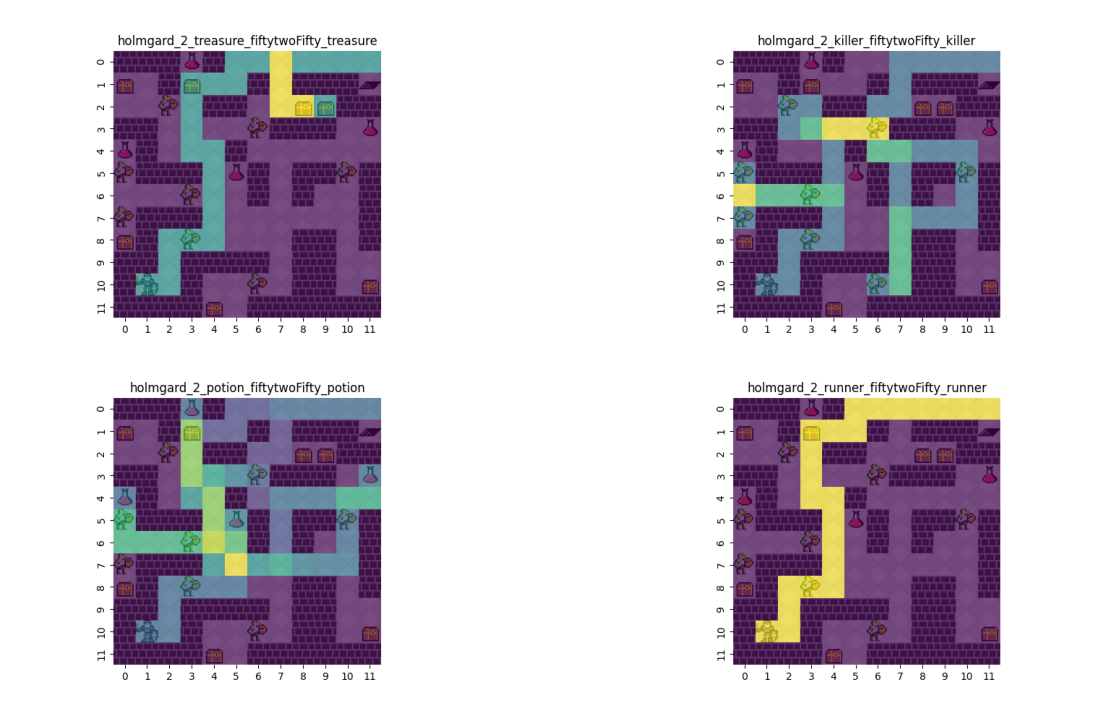

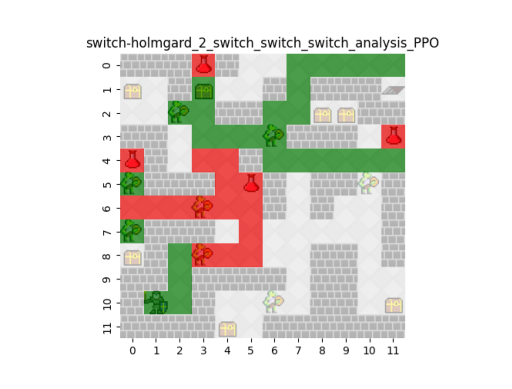

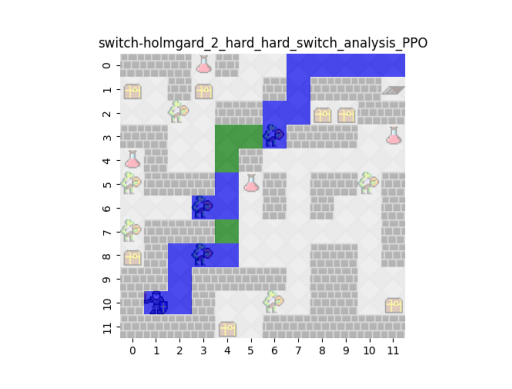

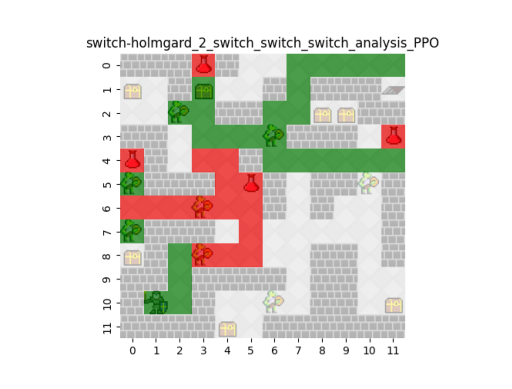

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_switch_switch_switch_analysis_PPO
action
KILLER    360
POTION    270
Name: count, dtype: int64
[<PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007CA63D0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20076BED60>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20411C8A00>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007C6A640>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20075B67C0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006B48B50>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20066EF9D0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007B77520>, <PIL.Image.Image image mode=RGB size=8

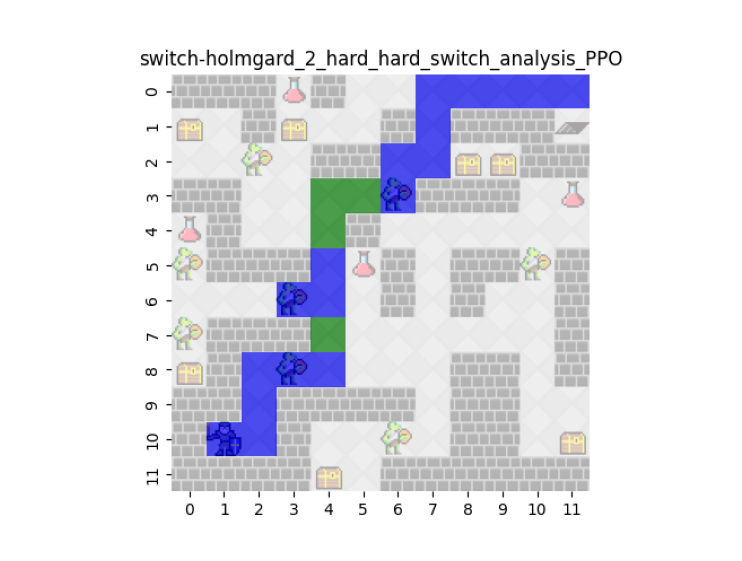

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_hard_hard_switch_analysis_PPO
action
RUNNER    180
KILLER     50
Name: count, dtype: int64
[<PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007A68AF0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007A77FA0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007AC14C0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20068131F0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20075024C0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006C24C10>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F200646FD90>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20067F5040>, <PIL.Image.Image image mode=RGB size=800x550 a

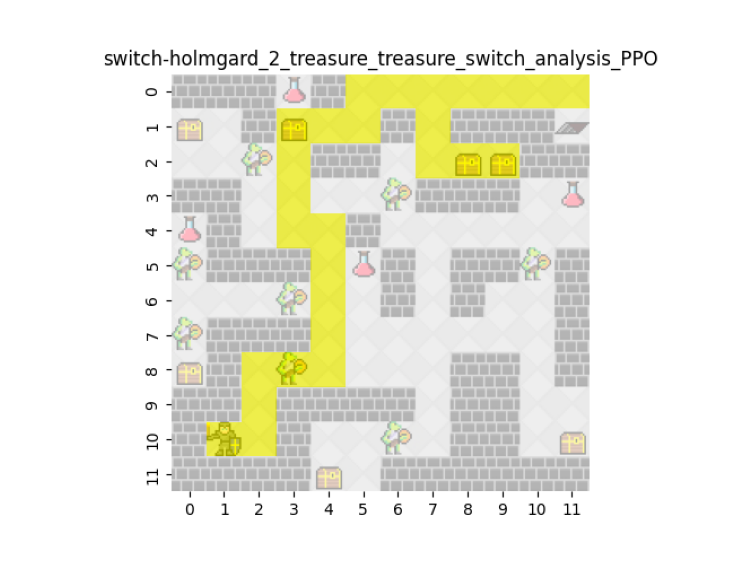

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_treasure_treasure_switch_analysis_PPO
action
TREASURE    310
Name: count, dtype: int64
[<PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006B7C250>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20410FA370>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F204059D400>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20411F87C0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007B62790>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006BF6B80>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006BD0D30>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F200750D790>, <PIL.Image.Image image mode=RGB size=800x5

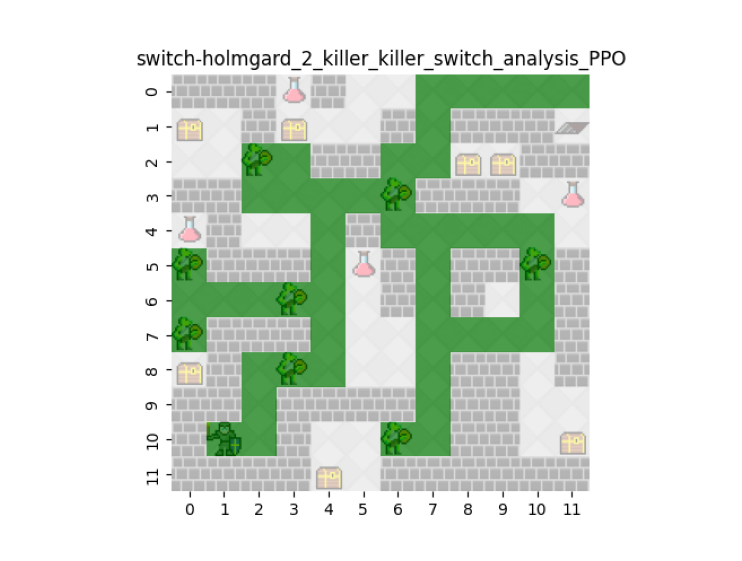

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'killer', 'reward_scheme': 'killer', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_killer_killer_switch_analysis_PPO
action
KILLER    670
Name: count, dtype: int64
[<PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006479160>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20068D4340>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20069FD8E0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20065CD760>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20065DD100>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2040EE46A0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F200684B460>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007C62CD0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F

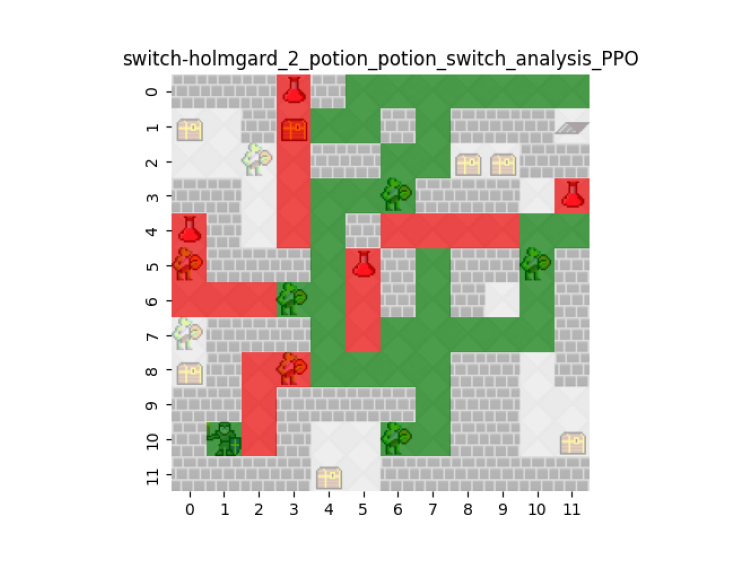

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'potion', 'reward_scheme': 'potion', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_potion_potion_switch_analysis_PPO
action
POTION    693
KILLER    233
Name: count, dtype: int64
[<PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006AE20A0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20404D2A60>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20063C17F0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20068312E0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F206E6C8C40>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007680AC0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F200769CC10>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007C0CDF0>, <PIL.Image.Image image mode=RGB size=8

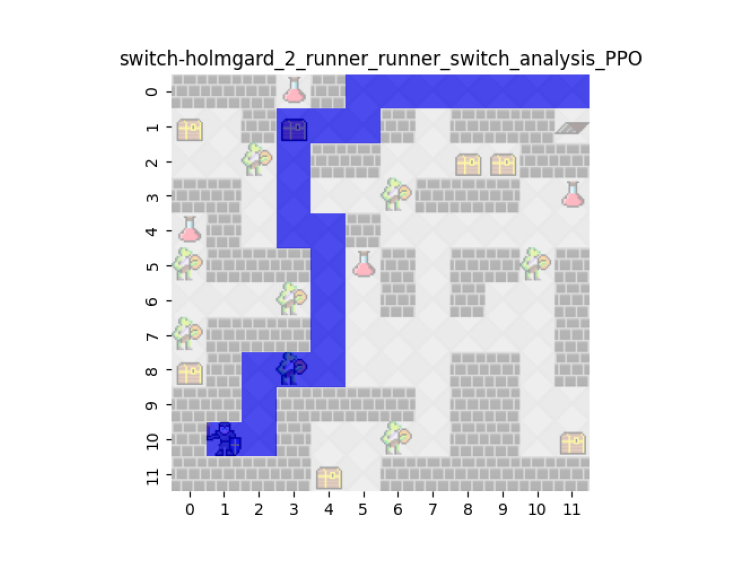

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_2', 'play_style': 'runner', 'reward_scheme': 'runner', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis'}
switch-holmgard_2_runner_runner_switch_analysis_PPO
action
RUNNER    230
Name: count, dtype: int64
[<PIL.Image.Image image mode=RGB size=800x550 at 0x7F2007646C40>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F200686C100>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006B7CE80>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2006203340>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20075E8C70>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F20077398B0>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F200698CA60>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F2040DF9B80>, <PIL.Image.Image image mode=RGB size=800x550 at 0x7F

In [10]:
EXPLAINER_TYPE = 'deep'
CLASS_NAMES =['Killer','Treasure','Runner','Potion']
gen_analysis(analysis_loc='./test_analysis/Holmgard_2_Analysis/', lvl='holmgard_2', obs_type = 'distance', explainer_type =EXPLAINER_TYPE)
plt.close()


In [ ]:
EXPLAINER_TYPE = 'deep'
CLASS_NAMES =['Killer','Treasure','Runner','Potion']
gen_analysis(analysis_loc='./test_analysis/Holmgard_2_Analysis/', lvl='holmgard_2', obs_type = 'distance', explainer_type =EXPLAINER_TYPE)
plt.close()


In [ ]:

f = "logs/switching_analysis/switch-hard_switch_switch_switch_analysis_PPO/switch/best_model.zip"
# from PIL import Image, ImageDraw, ImageFont
# # create an image
# out = Image.new("RGB", (150, 100), (255, 255, 255))

# # get a font
# fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
# # get a drawing context
# d = ImageDraw.Draw(out)

# # draw multiline text
# d.multiline_text((10, 10), "Hello\nWorld", font=fnt, fill=(0, 0, 0))

# out.show()

In [13]:
explainer, shap_values, data, df =shap_behaviour("policy_1", play_style="killer", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

TypeError: shap_behaviour() got an unexpected keyword argument 'play_style'

In [ ]:
model = DQN.load('logs/switching/switch-policy_2_switch_exitLessBnL_switchTest_DQN/switch/best_model.zip')

In [ ]:
model = sb3_DQN_wrapper(model)

In [ ]:
model.forward(torch.FloatTensor([11, 3, 3, 19, 19, 23, 23, 100]).to('cuda'))
model.forward(torch.FloatTensor([7, 1000, 1000, 15, 15, 19, 19, 100]).to('cuda'))


tensor([ -9.5719, -10.0105,  -9.9416, -10.3034], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
df

,experiment,level,run,step,x,y,hp,grid,play_style,action,curr_obs,observation,done,reward,info,grid_rows,grid_columns
0,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,0,-1,1,2,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,NO_ACTION,"[12, 4, 4, 20, 20, 24, 24, 100]","[12, 4, 4, 20, 20, 24, 24, 100]",False,0.0,{},5,21
1,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,0,0,2,2,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,TREASURE,"[12, 4, 4, 20, 20, 24, 24, 100]","[11, 3, 3, 19, 19, 23, 23, 100]",False,-1.0,"{'action_taken': 'TREASURE', 'TREASURE': 1, '....",5,21
2,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,0,1,2,1,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,TREASURE,"[11, 3, 3, 19, 19, 23, 23, 100]","[10, 2, 2, 18, 18, 22, 22, 100]",False,-1.0,"{'action_taken': 'TREASURE', 'TREASURE': 2, '....",5,21
3,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,0,2,3,1,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,TREASURE,"[10, 2, 2, 18, 18, 22, 22, 100]","[9, 1, 1, 17, 17, 21, 21, 100]",False,-1.0,"{'action_taken': 'TREASURE', 'TREASURE': 3, '....",5,21
4,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,0,3,4,1,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,TREASURE,"[9, 1, 1, 17, 17, 21, 21, 100]","[8, 0, 0, 16, 16, 20, 20, 100]",False,4.0,"{'action_taken': 'TREASURE', 'TREASURE': 4, '....",5,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,29,19,16,1,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,POTION,"[1000, 1000, 1000, 1, 1, 5, 5, 95]","[1000, 1000, 1000, 0, 0, 4, 4, 100]",False,0.0,"{'action_taken': 'POTION', 'POTION': 8, '.': 1...",5,21
717,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,29,20,17,1,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,POTION,"[1000, 1000, 1000, 0, 0, 4, 4, 100]","[1000, 1000, 1000, 1000, 1000, 3, 3, 100]",False,-1.0,"{'action_taken': 'POTION', 'POTION': 9, '.': 1...",5,21
718,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,29,21,18,1,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,POTION,"[1000, 1000, 1000, 1000, 1000, 3, 3, 100]","[1000, 1000, 1000, 1000, 1000, 2, 2, 100]",False,-1.0,"{'action_taken': 'POTION', 'POTION': 10, '.': ...",5,21
719,switch-policy_2_switch_exitLessBetter_switch_PPO,policy_2,29,22,18,2,100,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",switch,POTION,"[1000, 1000, 1000, 1000, 1000, 2, 2, 100]","[1000, 1000, 1000, 1000, 1000, 1, 1, 100]",False,-1.0,"{'action_taken': 'POTION', 'POTION': 11, '.': ...",5,21


## Holmgard_9

In [ ]:
config_h9={
    'action_type': 'switch',
    'lvl': 'holmgard_9',
    'play_style': 'hard',
    'reward_scheme': 'exitLessBetter4',
    'exp_type': 'switch',
    'learning_algo': 'PPO',
    'exp_path': 'switching',
}
config_base_treasure_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'treasure',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'treasure',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_killer_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'killer',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'killer',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_potion_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'potion',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'potion',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
config_base_runner_h9={
    'action_type': 'base',
    'lvl': 'holmgard_9',
    'play_style': 'runner',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'runner',
    'learning_algo': 'PPO',
    'exp_path': 'play_style_models/base/',
}
h9_config_killer_h9 ={
    'action_type': 'path',
    'lvl': 'holmgard_9',
    'play_style': 'killer',
    'reward_scheme': 'fiftytwoFifty',
    'exp_type': 'rewardShapingKillerLonger_1',
    'learning_algo': 'PPO',
    'exp_path': 'reward_shaping/',
}

switch-holmgard_9_hard_exitLessBetter4_switch_PPO


[ WARN:0@9995.714] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_9-v0_step0.png'): can't open/read file: check file path/integrity


holmgard_9_treasure_fiftytwoFifty_treasure


[ WARN:0@10000.096] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_9-v0_step0.png'): can't open/read file: check file path/integrity


holmgard_9_killer_fiftytwoFifty_killer


[ WARN:0@10003.831] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_9-v0_step0.png'): can't open/read file: check file path/integrity


holmgard_9_potion_fiftytwoFifty_potion


[ WARN:0@10009.529] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_9-v0_step0.png'): can't open/read file: check file path/integrity


holmgard_9_runner_fiftytwoFifty_runner
5


[ WARN:0@10011.334] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-holmgard_9-v0_step0.png'): can't open/read file: check file path/integrity


<Figure size 640x480 with 0 Axes>

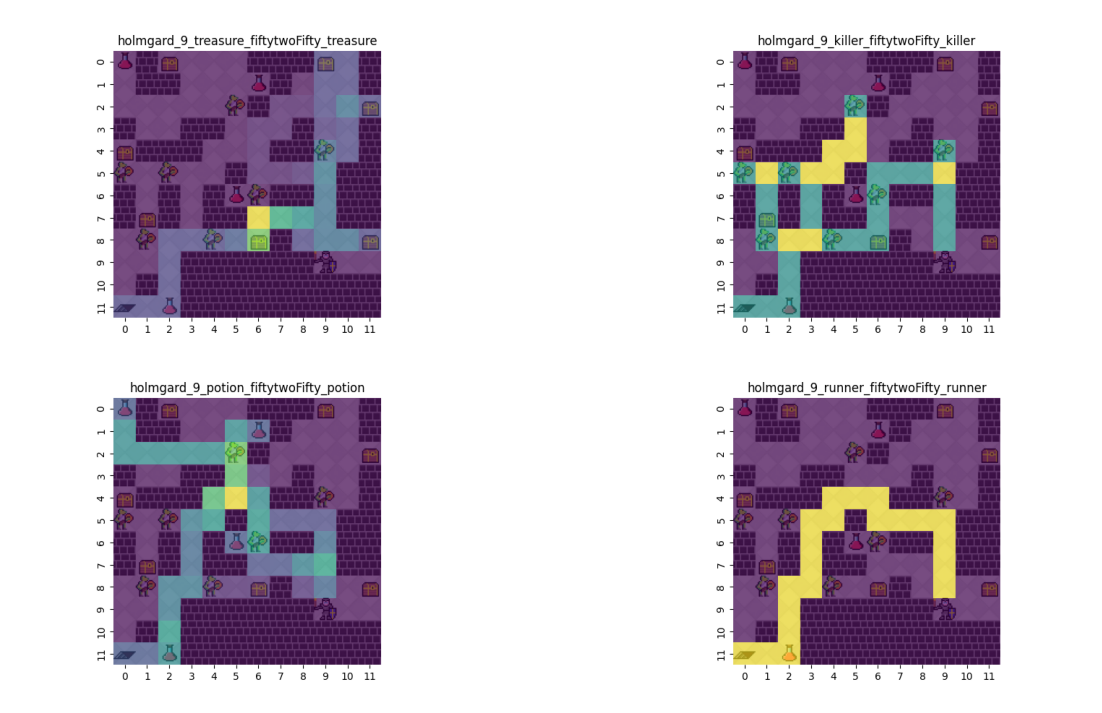

(-0.5, 639.5, 479.5, -0.5)

In [ ]:
configs_h9 = [config_h9, config_base_treasure_h9,config_base_killer_h9,config_base_potion_h9,config_base_runner_h9]
df, images =gen_action_data_img(configs_h9)
print(len(images))

f, axarr = plt.subplots(2,2, figsize=(16,9))
axarr[0,0].imshow(images[1])
axarr[0,0].axis('off')
axarr[0,0].set_aspect('equal')

axarr[0,1].imshow(images[2])
axarr[0,1].axis('off')
axarr[0,1].set_aspect('equal')
axarr[1,0].imshow(images[3])
axarr[1,0].axis('off')
axarr[1,0].set_aspect('equal')
axarr[1,1].imshow(images[4])
axarr[1,1].axis('off')
axarr[1,1].set_aspect('equal')
plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.show()
axarr[1,1].axis('off')
plt.imshow(images[0])
plt.axis('off')

switch-holmgard_9_hard_exitLessBetter4_switch_PPO


KILLER    421
RUNNER    209
Name: action, dtype: int64


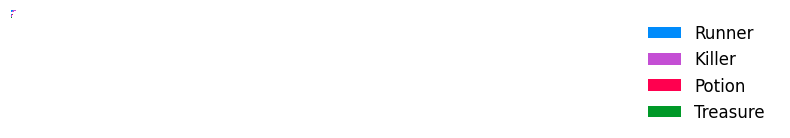

In [ ]:
explainer , shap_vals, data, df =shappy(config_h9)
shap.summary_plot(shap_vals,data, feature_names=obs_names, class_names =['Killer','Treasure','Runner','Potion'],plot_type='bar')

KILLER


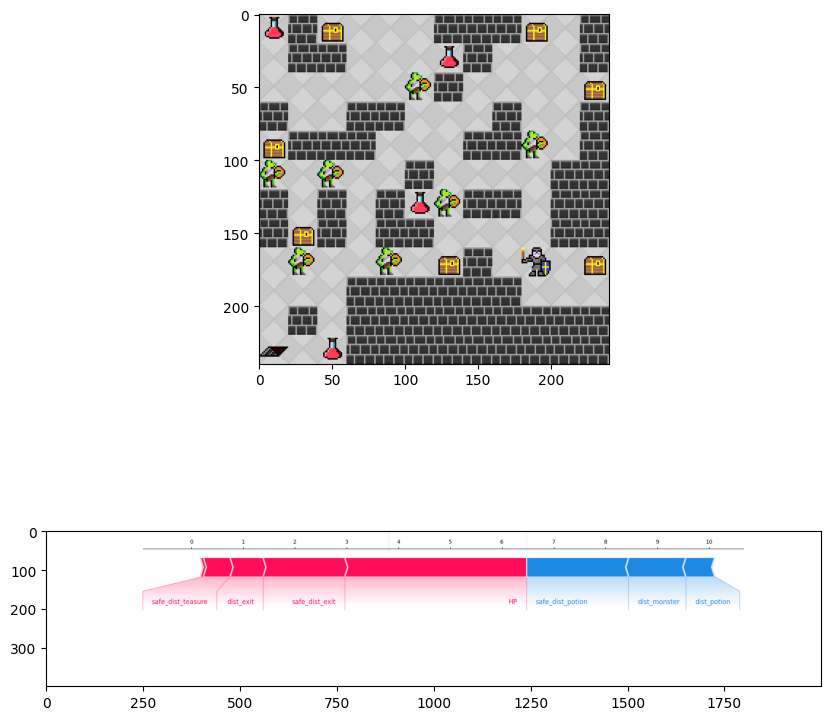

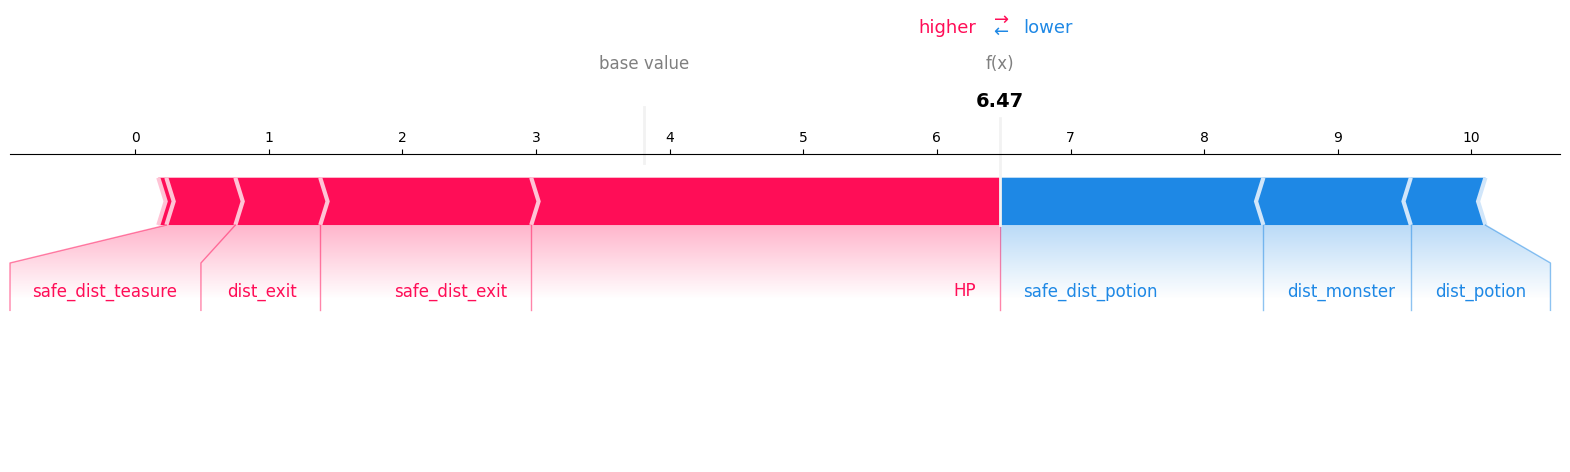

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
grid_img = ax1.imshow(state_image(df['curr_grid'][0], df['x'][0],df['y'][0],df['hp'][0]))
shap_img = ax2.imshow(shap_index(explainer,data,df, 0))
images.append([grid_img, shap_img])
plt.show()